# Volume-Level Inference Analysis

This notebook analyzes predictions for complete OCT volumes:
1. Find the volume with the most B-scans in the test split
2. Load the trained model and run inference on all B-scans
3. Visualize predictions vs ground truth for the entire volume

**Model**: `checkpoints12022205/best_model.pth`  
**Data**: Test split from `splits.json`

## 1. Import Libraries and Setup

In [1]:
import json
import pickle
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from tqdm import tqdm

# Import project modules
import sys
sys.path.insert(0, '/home/suraj/Git/RCNN-OCT')
from inference import load_model
from dataset import _extract_arrays, _load_pickle

# Configuration
CHECKPOINT_PATH = Path("/home/suraj/Git/RCNN-OCT/checkpoints12022205/best_model.pth")
SPLITS_FILE = Path("/home/suraj/Git/RCNN-OCT/splits.json")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Checkpoint: {CHECKPOINT_PATH}")
print(f"Splits file: {SPLITS_FILE}")

Device: cuda
Checkpoint: /home/suraj/Git/RCNN-OCT/checkpoints12022205/best_model.pth
Splits file: /home/suraj/Git/RCNN-OCT/splits.json


## 2. Parse Test Split and Find Volume with Most B-scans

B-scan numbering: File format is `patientID_LorR_instanceNumber_bscanNumber.pkl`  
- Example: `107_R_1025.pkl` = Patient 107, Right eye, Instance 1, B-scan 025 (26th scan, 0-indexed)

In [2]:
# Load splits
with open(SPLITS_FILE, 'r') as f:
    splits = json.load(f)

test_files = [Path(f) for f in splits['test']]
print(f"Total test files: {len(test_files)}")

# Parse volume information from filenames
# Format: patientID_LorR_instanceNumber.pkl (last 3 digits are B-scan number)
volume_bscans = defaultdict(list)

for file_path in test_files:
    filename = file_path.stem  # Get filename without extension
    
    # Parse: patientID_LorR_instance_bscanNumber
    parts = filename.split('_')
    if len(parts) >= 3:
        patient_id = parts[0]
        eye = parts[1]  # L or R
        instance_and_bscan = parts[2]
        
        # Extract instance number (first digit) and B-scan number (last 3 digits)
        if len(instance_and_bscan) >= 4:
            instance = instance_and_bscan[0]
            bscan_num = int(instance_and_bscan[-3:])  # Last 3 digits
            
            # Volume identifier: patientID_eye_instance
            volume_id = f"{patient_id}_{eye}_{instance}"
            
            volume_bscans[volume_id].append({
                'path': file_path,
                'bscan_num': bscan_num,
                'filename': filename
            })

# Sort B-scans within each volume
for volume_id in volume_bscans:
    volume_bscans[volume_id].sort(key=lambda x: x['bscan_num'])

# Find volume with most B-scans
volume_counts = {vol: len(bscans) for vol, bscans in volume_bscans.items()}
max_volume = max(volume_counts, key=volume_counts.get)
max_count = volume_counts[max_volume]

print(f"\n{'='*60}")
print(f"Volume with most B-scans: {max_volume}")
print(f"Number of B-scans: {max_count}")
print(f"{'='*60}")

# Display top 10 volumes by B-scan count
print("\nTop 10 volumes by B-scan count:")
sorted_volumes = sorted(volume_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (vol, count) in enumerate(sorted_volumes, 1):
    marker = " ⭐ (Selected)" if vol == max_volume else ""
    print(f"{i:2d}. {vol:20s} - {count:2d} B-scans{marker}")

# Get B-scans for selected volume
selected_bscans = volume_bscans[max_volume]
print(f"\nB-scan range for {max_volume}:")
print(f"  First: {selected_bscans[0]['bscan_num']:03d} - {selected_bscans[0]['filename']}")
print(f"  Last:  {selected_bscans[-1]['bscan_num']:03d} - {selected_bscans[-1]['filename']}")

Total test files: 1263

Volume with most B-scans: 108_L_1
Number of B-scans: 10

Top 10 volumes by B-scan count:
 1. 108_L_1              - 10 B-scans ⭐ (Selected)
 2. 133_L_1              -  9 B-scans
 3. 135_R_1              -  9 B-scans
 4. 3_R_5                -  8 B-scans
 5. 129_R_1              -  7 B-scans
 6. 80_L_2               -  7 B-scans
 7. 12_R_1               -  7 B-scans
 8. 110_L_1              -  7 B-scans
 9. 53_R_1               -  7 B-scans
10. 90_R_3               -  7 B-scans

B-scan range for 108_L_1:
  First: 005 - 108_L_1005
  Last:  030 - 108_L_1030


In [ ]:
# Set another volume
# selected_volumes = 

## 3. Load Model

In [3]:
# Load trained model
print("Loading model...")
model = load_model(CHECKPOINT_PATH, device=DEVICE)
model.eval()
print("Model loaded successfully!")

Loading model...
Model loaded successfully!
Model loaded successfully!


## 4. Run Inference on All B-scans in Selected Volume

In [4]:
def run_inference_on_bscan(model, file_path, device, score_threshold=0.5):
    """Run inference on a single B-scan."""
    # Load pickle file
    sample = _load_pickle(file_path)
    image_np, gt_boxes, gt_labels = _extract_arrays(sample)
    
    # Prepare image tensor
    image_np = np.asarray(image_np, dtype=np.float32)
    if image_np.max() > 1.0:
        image_np = image_np / 255.0
    
    image_tensor = torch.from_numpy(image_np)
    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0)
    
    if image_tensor.shape[0] == 1:
        image_tensor = image_tensor.repeat(3, 1, 1)
    
    # Run inference
    with torch.no_grad():
        outputs = model([image_tensor.to(device)])
    
    output = outputs[0]
    pred_boxes = output["boxes"].cpu().numpy()
    pred_scores = output["scores"].cpu().numpy()
    pred_labels = output["labels"].cpu().numpy()
    
    # Filter by score threshold
    keep = pred_scores >= score_threshold
    pred_boxes = pred_boxes[keep]
    pred_scores = pred_scores[keep]
    pred_labels = pred_labels[keep]
    
    return {
        'image': image_tensor.cpu(),
        'pred_boxes': pred_boxes,
        'pred_scores': pred_scores,
        'pred_labels': pred_labels,
        'gt_boxes': gt_boxes,
        'gt_labels': gt_labels
    }

# Run inference on all B-scans in selected volume
print(f"Running inference on {len(selected_bscans)} B-scans from volume {max_volume}...")
print(f"Score threshold: 0.5\n")

results = []
for bscan_info in tqdm(selected_bscans, desc="Processing B-scans"):
    result = run_inference_on_bscan(model, bscan_info['path'], DEVICE, score_threshold=0.5)
    result['bscan_num'] = bscan_info['bscan_num']
    result['filename'] = bscan_info['filename']
    results.append(result)

print(f"\n✓ Inference complete for {len(results)} B-scans")

Running inference on 10 B-scans from volume 108_L_1...
Score threshold: 0.5



Processing B-scans: 100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


✓ Inference complete for 10 B-scans


## 5. Compute Volume-Level Statistics

In [5]:
# Compute statistics
total_gt_boxes = sum(len(r['gt_boxes']) for r in results)
total_pred_boxes = sum(len(r['pred_boxes']) for r in results)

# Count by label
gt_label_counts = defaultdict(int)
pred_label_counts = defaultdict(int)

for result in results:
    for label in result['gt_labels']:
        gt_label_counts[int(label)] += 1
    for label in result['pred_labels']:
        pred_label_counts[int(label)] += 1

label_names = {1: "Fovea", 2: "SCR"}

print(f"{'='*60}")
print(f"Volume Statistics: {max_volume}")
print(f"{'='*60}")
print(f"Total B-scans: {len(results)}")
print(f"B-scan range: {results[0]['bscan_num']:03d} to {results[-1]['bscan_num']:03d}")
print(f"\nGround Truth:")
print(f"  Total boxes: {total_gt_boxes}")
for label, count in sorted(gt_label_counts.items()):
    label_name = label_names.get(label, f"Class {label}")
    print(f"    {label_name}: {count}")

print(f"\nPredictions:")
print(f"  Total boxes: {total_pred_boxes}")
for label, count in sorted(pred_label_counts.items()):
    label_name = label_names.get(label, f"Class {label}")
    print(f"    {label_name}: {count}")
print(f"{'='*60}")

Volume Statistics: 108_L_1
Total B-scans: 10
B-scan range: 005 to 030

Ground Truth:
  Total boxes: 10
    Class 0: 2
    SCR: 8

Predictions:
  Total boxes: 2
    Fovea: 2


## 6. Visualize All B-scans: Predictions vs Ground Truth

Color coding:
- 🟢 **Green**: Fovea (Label 1)
- 🔴 **Red**: SCR - Sub-Clinical Retinal (Label 2)

In [6]:
def visualize_bscan_comparison(result, save_path=None, show_plot=True):
    """Visualize ground truth vs predictions for a single B-scan."""
    label_names = {1: "Fovea", 2: "SCR"}
    label_colors = {1: "green", 2: "red"}
    
    # Get image
    image = result['image']
    if image.dim() == 3 and image.shape[0] == 3:
        image_np = image[0].numpy()
    else:
        image_np = image.squeeze().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot ground truth
    ax1.imshow(image_np, cmap="gray")
    ax1.set_title(f"Ground Truth - B-scan {result['bscan_num']:03d}", 
                  fontsize=14, fontweight="bold")
    ax1.axis("off")
    
    for box, label in zip(result['gt_boxes'], result['gt_labels']):
        label_int = int(label)
        color = label_colors.get(label_int, "yellow")
        label_text = label_names.get(label_int, f"Class {label_int}")
        
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2.5, edgecolor=color, facecolor="none"
        )
        ax1.add_patch(rect)
        
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7, edgecolor="none")
        ax1.text(
            x1, y1 - 8, f"GT: {label_text}", 
            color="white", fontsize=10, weight="bold", 
            bbox=bbox_props, verticalalignment="top"
        )
    
    # Plot predictions
    ax2.imshow(image_np, cmap="gray")
    ax2.set_title(f"Predictions - B-scan {result['bscan_num']:03d}", 
                  fontsize=14, fontweight="bold")
    ax2.axis("off")
    
    for box, score, label in zip(result['pred_boxes'], result['pred_scores'], result['pred_labels']):
        label_int = int(label)
        color = label_colors.get(label_int, "yellow")
        label_text = label_names.get(label_int, f"Class {label_int}")
        
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2.5, edgecolor=color, facecolor="none"
        )
        ax2.add_patch(rect)
        
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7, edgecolor="none")
        ax2.text(
            x1, y1 - 8, f"{label_text}: {score:.2f}", 
            color="white", fontsize=10, weight="bold", 
            bbox=bbox_props, verticalalignment="top"
        )
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    
    if show_plot:
        plt.show()
    else:
        plt.close()

# Create output directory
output_dir = Path(f"inference_results/volume_{max_volume}")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Generating visualizations for {len(results)} B-scans...")
print(f"Output directory: {output_dir}\n")

# Generate and save all visualizations
for i, result in enumerate(tqdm(results, desc="Creating visualizations")):
    save_path = output_dir / f"bscan_{result['bscan_num']:03d}.png"
    visualize_bscan_comparison(result, save_path=save_path, show_plot=False)

print(f"\n✓ All visualizations saved to: {output_dir}")

Generating visualizations for 10 B-scans...
Output directory: inference_results/volume_108_L_1



Creating visualizations: 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


✓ All visualizations saved to: inference_results/volume_108_L_1


## 7. Display Sample Visualizations

Let's display a few samples from different parts of the volume (beginning, middle, end).

Displaying 3 sample B-scans:

B-scan 005: 1 GT boxes, 0 predictions


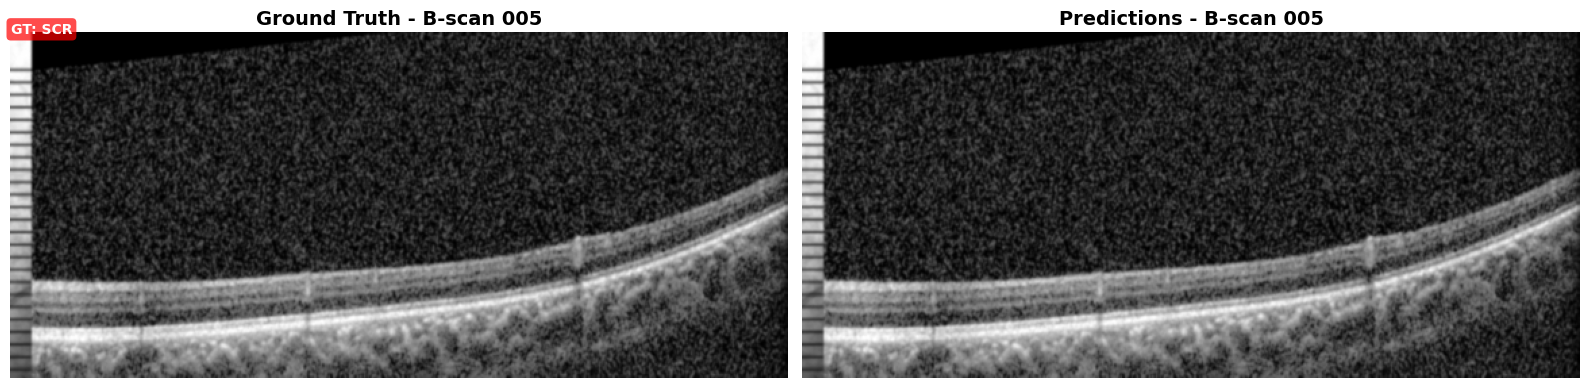

B-scan 017: 1 GT boxes, 1 predictions


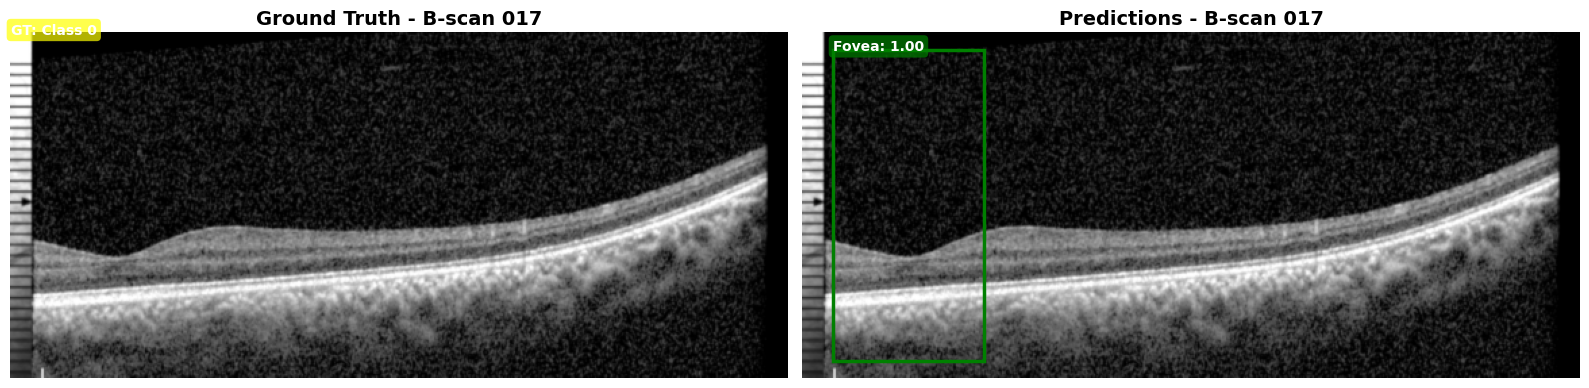

B-scan 030: 1 GT boxes, 0 predictions


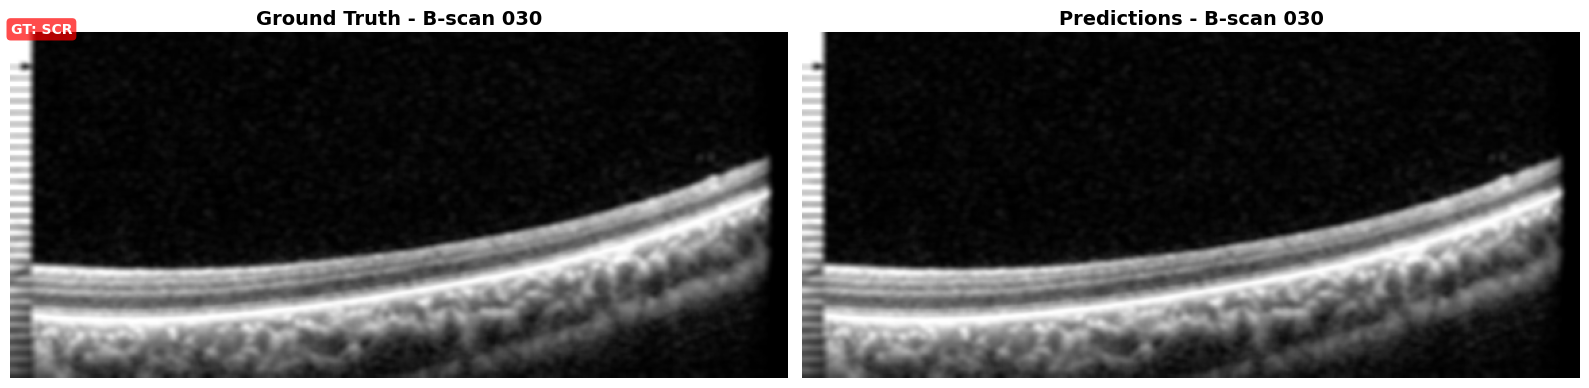

In [ ]:
# Select sample B-scans: beginning, middle, end
num_bscans = len(results)
sample_indices = [
    0,                      # First B-scan
    num_bscans // 2,        # Middle B-scan
    num_bscans - 1          # Last B-scan
]

print(f"Displaying {len(sample_indices)} sample B-scans:\n")

for idx in sample_indices:
    result = results[idx]
    print(f"B-scan {result['bscan_num']:03d}: "
          f"{len(result['gt_boxes'])} GT boxes, "
          f"{len(result['pred_boxes'])} predictions")
    visualize_bscan_comparison(result, show_plot=True)

## 8. Summary Report

Generate a summary of detection performance across the volume.

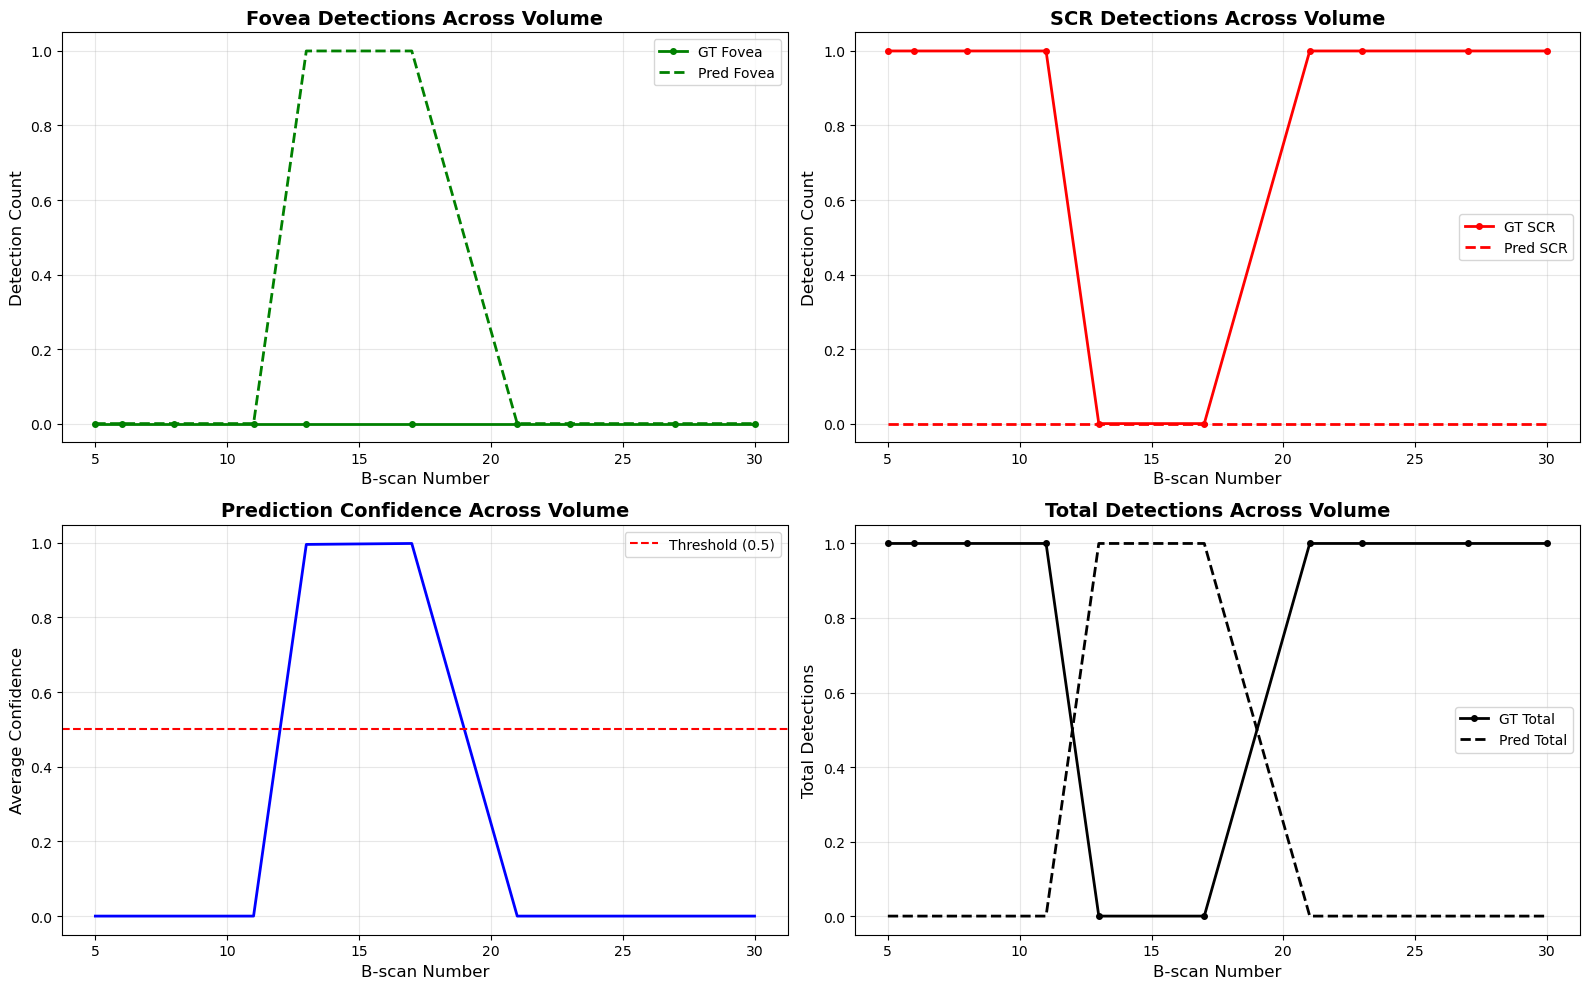


✓ Summary report saved to: inference_results/volume_108_L_1/volume_summary.png

VOLUME-LEVEL SUMMARY: 108_L_1
Total B-scans analyzed: 10
B-scan range: 005 - 030

Ground Truth:
  - Fovea detections: 0
  - SCR detections: 8
  - Total: 8

Predictions:
  - Fovea detections: 2
  - SCR detections: 0
  - Total: 2
  - Average confidence: 0.199

All visualizations saved to: inference_results/volume_108_L_1


In [8]:
# Calculate per-B-scan statistics
bscan_stats = []
for result in results:
    stats = {
        'bscan_num': result['bscan_num'],
        'gt_fovea': sum(1 for l in result['gt_labels'] if l == 1),
        'gt_scr': sum(1 for l in result['gt_labels'] if l == 2),
        'pred_fovea': sum(1 for l in result['pred_labels'] if l == 1),
        'pred_scr': sum(1 for l in result['pred_labels'] if l == 2),
        'avg_confidence': np.mean(result['pred_scores']) if len(result['pred_scores']) > 0 else 0.0
    }
    bscan_stats.append(stats)

# Create summary plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Detection counts across B-scans
ax = axes[0, 0]
bscan_nums = [s['bscan_num'] for s in bscan_stats]
gt_fovea_counts = [s['gt_fovea'] for s in bscan_stats]
pred_fovea_counts = [s['pred_fovea'] for s in bscan_stats]

ax.plot(bscan_nums, gt_fovea_counts, 'go-', label='GT Fovea', linewidth=2, markersize=4)
ax.plot(bscan_nums, pred_fovea_counts, 'g--', label='Pred Fovea', linewidth=2, markersize=4)
ax.set_xlabel('B-scan Number', fontsize=12)
ax.set_ylabel('Detection Count', fontsize=12)
ax.set_title('Fovea Detections Across Volume', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: SCR detections across B-scans
ax = axes[0, 1]
gt_scr_counts = [s['gt_scr'] for s in bscan_stats]
pred_scr_counts = [s['pred_scr'] for s in bscan_stats]

ax.plot(bscan_nums, gt_scr_counts, 'ro-', label='GT SCR', linewidth=2, markersize=4)
ax.plot(bscan_nums, pred_scr_counts, 'r--', label='Pred SCR', linewidth=2, markersize=4)
ax.set_xlabel('B-scan Number', fontsize=12)
ax.set_ylabel('Detection Count', fontsize=12)
ax.set_title('SCR Detections Across Volume', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Average confidence scores
ax = axes[1, 0]
confidences = [s['avg_confidence'] for s in bscan_stats]
ax.plot(bscan_nums, confidences, 'b-', linewidth=2)
ax.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
ax.set_xlabel('B-scan Number', fontsize=12)
ax.set_ylabel('Average Confidence', fontsize=12)
ax.set_title('Prediction Confidence Across Volume', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Total detections comparison
ax = axes[1, 1]
total_gt = [s['gt_fovea'] + s['gt_scr'] for s in bscan_stats]
total_pred = [s['pred_fovea'] + s['pred_scr'] for s in bscan_stats]

ax.plot(bscan_nums, total_gt, 'ko-', label='GT Total', linewidth=2, markersize=4)
ax.plot(bscan_nums, total_pred, 'k--', label='Pred Total', linewidth=2, markersize=4)
ax.set_xlabel('B-scan Number', fontsize=12)
ax.set_ylabel('Total Detections', fontsize=12)
ax.set_title('Total Detections Across Volume', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
summary_plot_path = output_dir / "volume_summary.png"
plt.savefig(summary_plot_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"\n✓ Summary report saved to: {summary_plot_path}")

# Print text summary
print("\n" + "="*60)
print(f"VOLUME-LEVEL SUMMARY: {max_volume}")
print("="*60)
print(f"Total B-scans analyzed: {len(results)}")
print(f"B-scan range: {min(bscan_nums):03d} - {max(bscan_nums):03d}")
print(f"\nGround Truth:")
print(f"  - Fovea detections: {sum(gt_fovea_counts)}")
print(f"  - SCR detections: {sum(gt_scr_counts)}")
print(f"  - Total: {sum(total_gt)}")
print(f"\nPredictions:")
print(f"  - Fovea detections: {sum(pred_fovea_counts)}")
print(f"  - SCR detections: {sum(pred_scr_counts)}")
print(f"  - Total: {sum(total_pred)}")
print(f"  - Average confidence: {np.mean(confidences):.3f}")
print(f"\nAll visualizations saved to: {output_dir}")
print("="*60)